### В данном уроке мы выделим еще несколько потенциально важных фичей из изначального датасета и попробуем применить изученные методы отбора признаков к итоговому датасету.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import os

In [2]:
data_path = os.path.abspath(os.path.join(os.getcwd(), os.pardir))+'/data/'

processed_data = pd.read_csv(data_path+'processed_data.csv', index_col='id')

processed_data.head()

,vendor_id,passenger_count,store_and_fwd_flag,trip_duration,distance_km
id,,,,,
id2875421,1,930.399753,0,455.0,1.500479
id2377394,0,930.399753,0,663.0,1.807119
id3858529,1,930.399753,0,2124.0,6.392080
id3504673,1,930.399753,0,429.0,1.487155
id2181028,1,930.399753,0,435.0,1.189925


In [3]:
initial_data = pd.read_csv(data_path+"taxi_dataset.csv")
initial_data.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N


In [4]:
initial_data.shape[0] == processed_data.shape[0]

True

In [5]:
### Установим id как индекс в initial_data

initial_data = initial_data.set_index("id")

In [6]:
### Вернем в датасет колонку pickup_datetime
### left_index = True, rigth_index = True говорит,
### что нужно использовать индексы датафреймов как ключи для их соединения

processed_data = processed_data.merge(initial_data["pickup_datetime"],
                                      left_index = True,
                                      right_index = True)

processed_data.head()

,vendor_id,passenger_count,store_and_fwd_flag,trip_duration,distance_km,pickup_datetime
id,,,,,,
id2875421,1,930.399753,0,455.0,1.500479,2016-03-14 17:24:55
id2377394,0,930.399753,0,663.0,1.807119,2016-06-12 00:43:35
id3858529,1,930.399753,0,2124.0,6.392080,2016-01-19 11:35:24
id3504673,1,930.399753,0,429.0,1.487155,2016-04-06 19:32:31
id2181028,1,930.399753,0,435.0,1.189925,2016-03-26 13:30:55


Напомним, **pickup_datetime** - время начала поездки.

Кажется, что в зависимости от месяца/дня недели/времени суток движение на дорогах может отличаться. Как из-за погодных условий, так и из-за загруженности транспорта. Поэтому, есть подозрение, что будет полезно выделить ряд признаков из колонки **pickup_datetime**. Давайте исследуем зависимость нашей таргетной переменной от указанных факторов.

In [7]:
### переводим колонку pickup_datetime в тип даты

processed_data["pickup_datetime"] = pd.to_datetime(processed_data["pickup_datetime"])
processed_data.dtypes

vendor_id                      int64
passenger_count              float64
store_and_fwd_flag             int64
trip_duration                float64
distance_km                  float64
pickup_datetime       datetime64[ns]
dtype: object

In [8]:
### выделяем из pickup_datetime месяц, дату, день недели и час

processed_data['pickup_datetime'] = pd.to_datetime(processed_data['pickup_datetime'])

processed_data['date'] = processed_data.pickup_datetime.dt.date
processed_data['day_of_week'] = processed_data.pickup_datetime.dt.dayofweek
processed_data['hour'] = processed_data.pickup_datetime.dt.hour
processed_data['month'] = processed_data.pickup_datetime.dt.month
processed_data['log_trip_duration'] = np.log1p(processed_data['trip_duration'])
processed_data.drop('trip_duration', axis=1, inplace=True)

Исследуем, когда и сколько поездок было совершено. 

Начнем с графиков, показывающих количество поездок в зависимости от времени суток/даты и т.д.

Так же полезно сразу показать и среднее значение таргетной переменной.

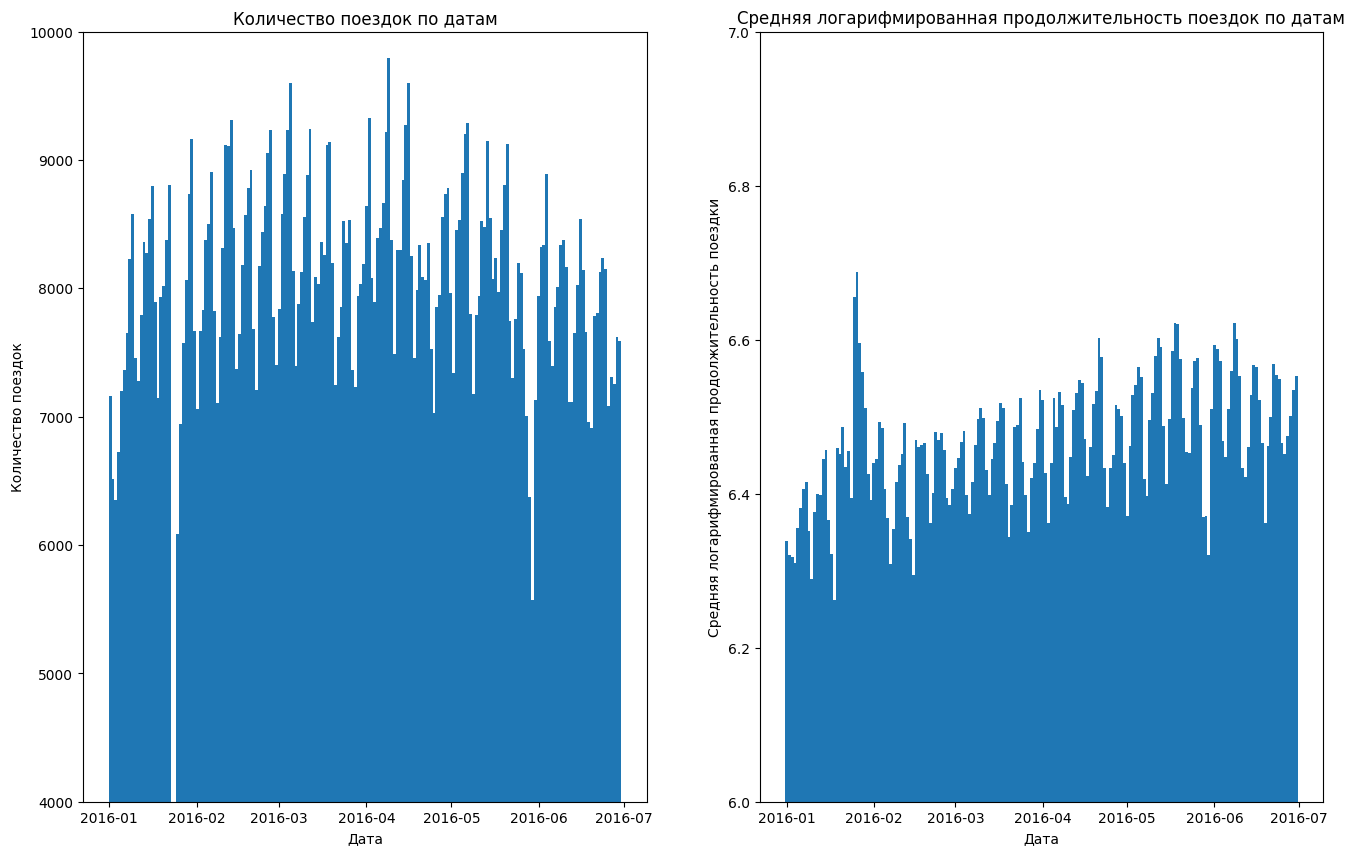

In [9]:
import matplotlib.pyplot as plt

fig = plt.figure()

fig.set_size_inches(16, 10)

fig.add_subplot(1, 2, 1)
plt.hist(processed_data.date, bins = processed_data.date.nunique())
plt.ylim((4000, 10000))
plt.title("Количество поездок по датам")
plt.xlabel("Дата")
plt.ylabel("Количество поездок")

fig.add_subplot(1, 2, 2)
plt.bar(sorted(processed_data.date.unique()),
        processed_data.groupby("date")["log_trip_duration"].mean(),
        width = 1)
plt.ylim((6, 7))

plt.title("Средняя логарифмированная продолжительность поездок по датам")
plt.xlabel("Дата")
plt.ylabel("Средняя логарифмированная продолжительность поездки")

plt.show()

Кажется, что внутри недели есть некоторая зависимость таргета от дня недели. 

Такая же зависимость может оказаться и внутри дня (в завимости от часов).

Предлагаю исследовать эту зависимость подробнее.

Изобразите следующие графики зависимостей:

- Количество поездок/Средняя продолжительность поездки vs День недели
- Количество поездок/Средняя продолжительность поездки vs время суток
- Средняя продолжительность поездки vs время суток для каждого дня недели (например, нарисовав с разными цветами и, соответственно, легендами)
- Аналогичные графики, используя информацию о месяце, внутри которого была совершена поездка.
- Ящики с усами для различных: времени суток, дня недели, месяца

Используйте любые доступные инструменты pyplot!

Далее, на основе полученных результатов, мы будем принимать решение о создании новых признаков.

EDA можно использовать не только для того, чтобы понять, какие фичи можно убрать из датасета. Но и для выделения базовых признаков. Этим и займемся!

P.S. Сами графики мы проверять у Вас не будем. Зато для ответа на устные вопросы понадобятся, поэтому, в любом случае, крайне рекомендуем поупражняться. Поэтому рисовать все графики не обязательно - ограничьтесь теми, которые помогут Вам ответить на тестовые вопросы.

**Hint**: обратите внимание на сильную просадку в январе. Почему она могла произойти - можно прочитать <a href="https://en.wikipedia.org/wiki/January_2016_United_States_blizzard"> здесь</a>. В будущем можно будет создать бинарный признак "произошла ли поездка во время сильного снегопада".


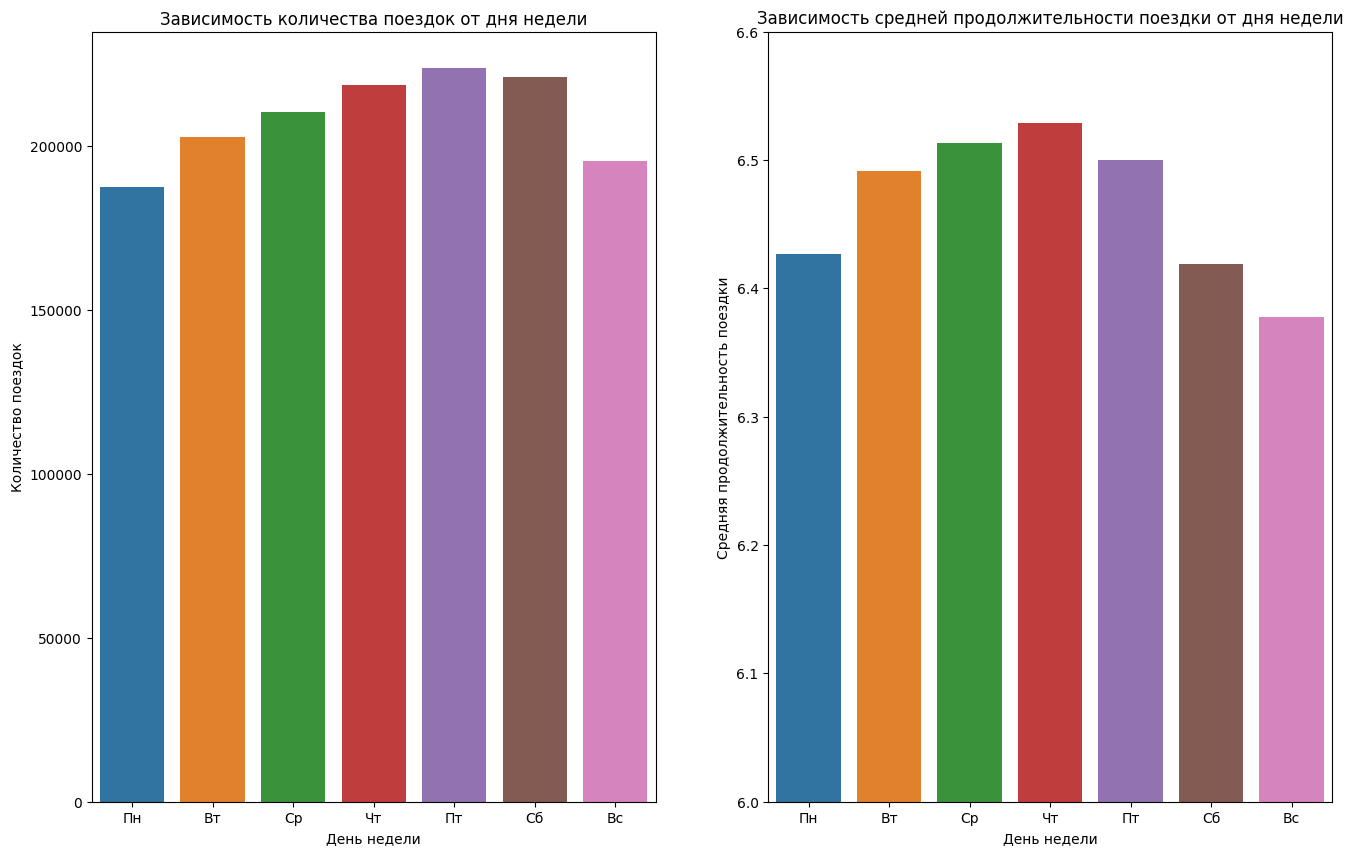

In [10]:
### График зависимости количества поездок от дня недели и 
### График зависимости средней продолжительности поездки от дня недели

fig = plt.figure()
fig.set_size_inches(16, 10)

fig.add_subplot(1, 2, 1)

sns.countplot(data = processed_data, x = "day_of_week")
plt.xticks(sorted(processed_data["day_of_week"].unique()),
           ["Пн", "Вт", "Ср", "Чт", "Пт", "Сб", "Вс"])
plt.xlabel("День недели")
plt.ylabel("Количество поездок")
plt.title("Зависимость количества поездок от дня недели")

fig.add_subplot(1, 2, 2)

sns.barplot(x = sorted(processed_data.day_of_week.unique()),
            y = processed_data.groupby("day_of_week")["log_trip_duration"].mean())
plt.xticks(sorted(processed_data.day_of_week.unique()),
           ["Пн", "Вт", "Ср", "Чт", "Пт", "Сб", "Вс"])
plt.xlabel("День недели")
plt.ylabel("Средняя продолжительность поездки")
plt.title("Зависимость средней продолжительности поездки от дня недели")
plt.ylim(6, 6.6)

plt.show()

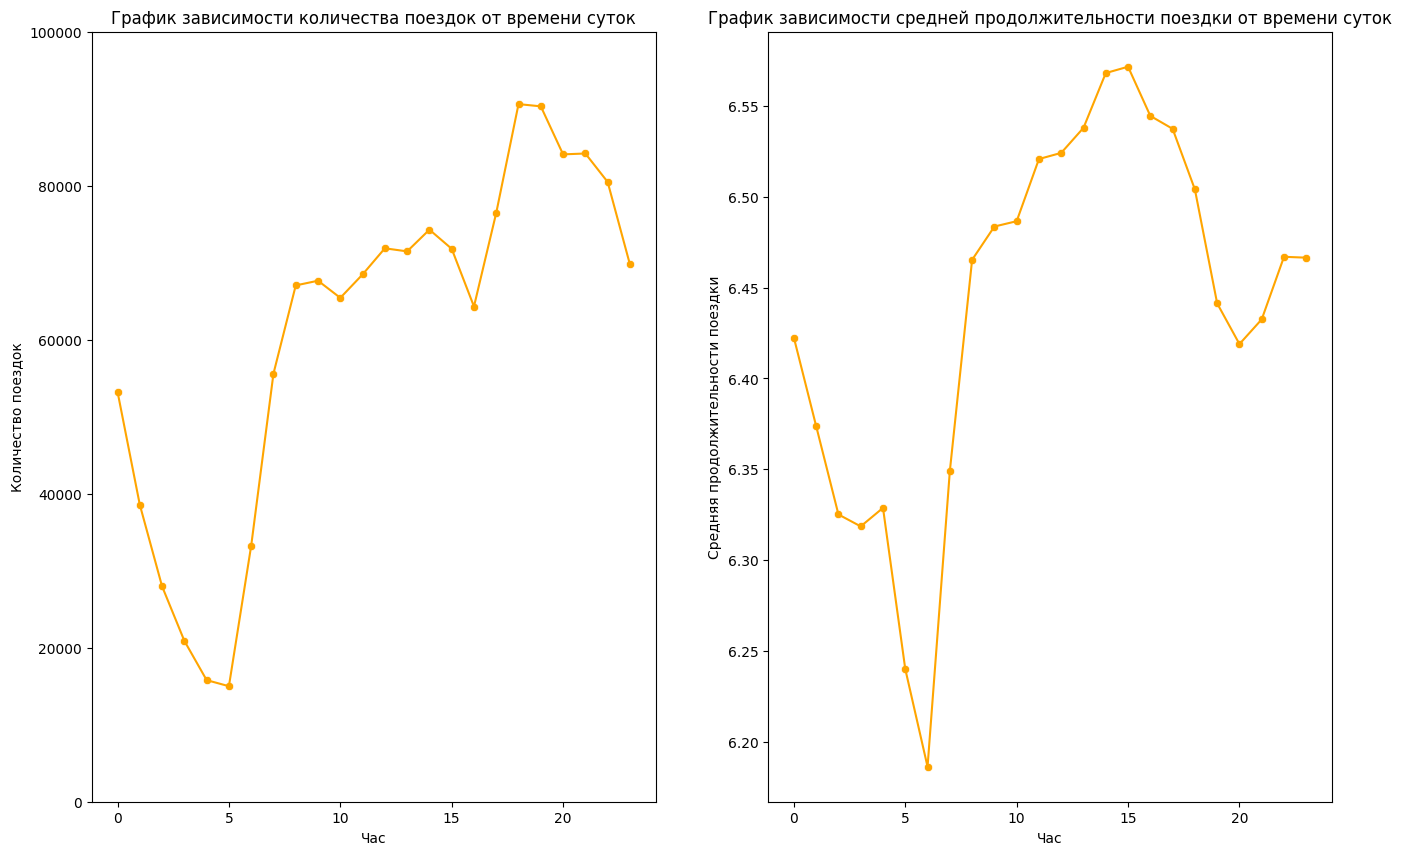

In [11]:
# График зависимости количества поездок от времени суток
# График зависимости средней продолжительности поездки от времени суток

fig = plt.figure()
fig.set_size_inches(16, 10)

fig.add_subplot(1, 2, 1)

sns.scatterplot(x = sorted(processed_data.hour.unique()),
                y = processed_data.hour.value_counts().sort_index(),
                color = "orange")
sns.lineplot(x = sorted(processed_data.hour.unique()),
             y = processed_data.hour.value_counts().sort_index(),
             color = "orange")
plt.ylim((0, 100000))
plt.title("График зависимости количества поездок от времени суток")
plt.xlabel("Час")
plt.ylabel("Количество поездок")

fig.add_subplot(1, 2, 2)

sns.scatterplot(x = sorted(processed_data["hour"].unique()),
                y = processed_data.groupby("hour")["log_trip_duration"].mean(),
                color = "orange")
sns.lineplot(x = sorted(processed_data["hour"].unique()),
             y = processed_data.groupby("hour")["log_trip_duration"].mean(), 
             color = "orange")
plt.title("График зависимости средней продолжительности поездки от времени суток")
plt.xlabel("Час")
plt.ylabel("Средняя продолжительности поездки")

plt.show()

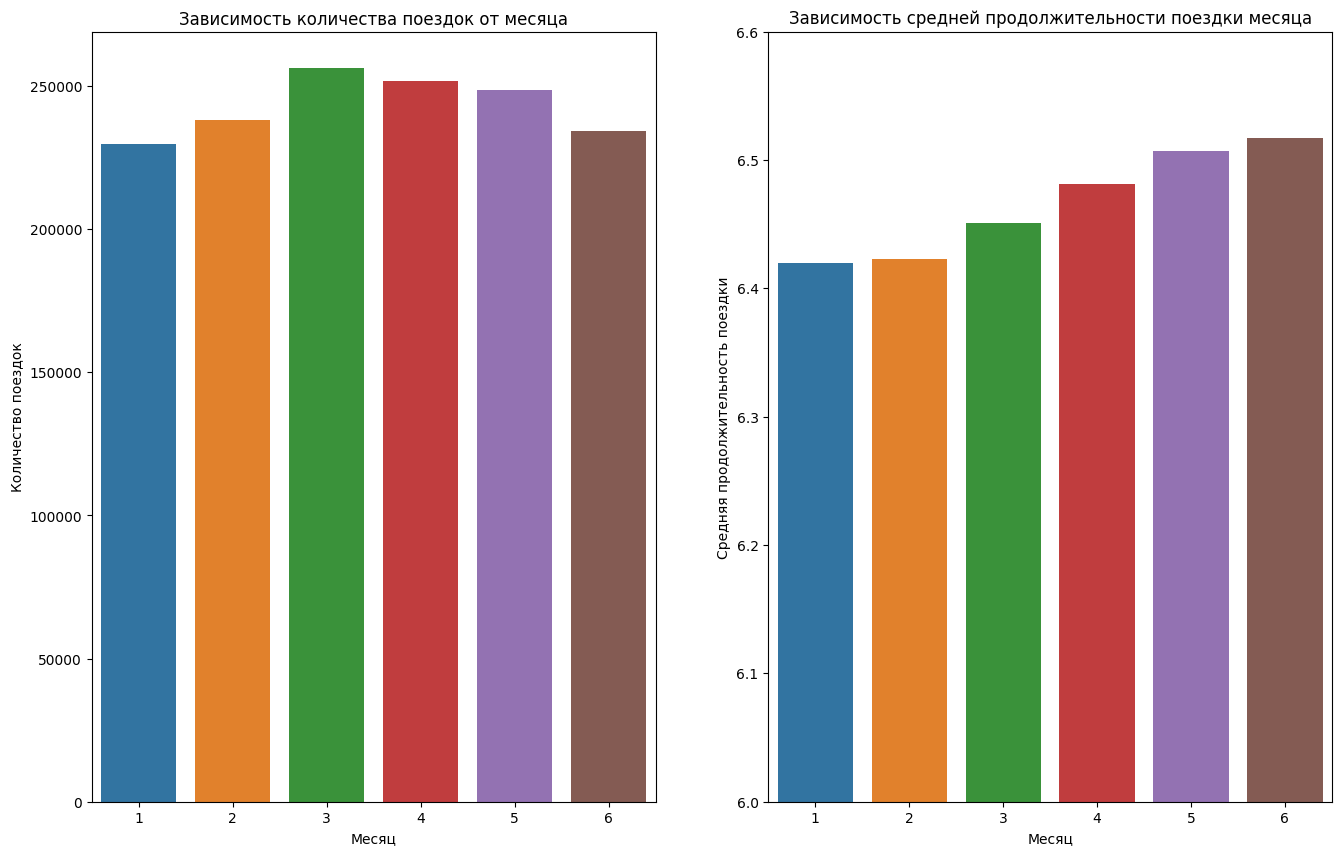

In [12]:
### График зависимости количества поездок от месяца и 
### График зависимости средней продолжительности поездки от месяца

fig = plt.figure()
fig.set_size_inches(16, 10)

fig.add_subplot(1, 2, 1)

sns.countplot(data = processed_data, x = "month")
plt.title("Зависимость количества поездок от месяца")
plt.xlabel("Месяц")
plt.ylabel("Количество поездок")

fig.add_subplot(1, 2, 2)
sns.barplot(x = sorted(processed_data.month.unique()),
            y = processed_data.groupby("month")["log_trip_duration"].mean())
plt.xlabel("Месяц")
plt.ylabel("Средняя продолжительность поездки")
plt.title("Зависимость средней продолжительности поездки месяца")
plt.ylim(6, 6.6)

plt.show()

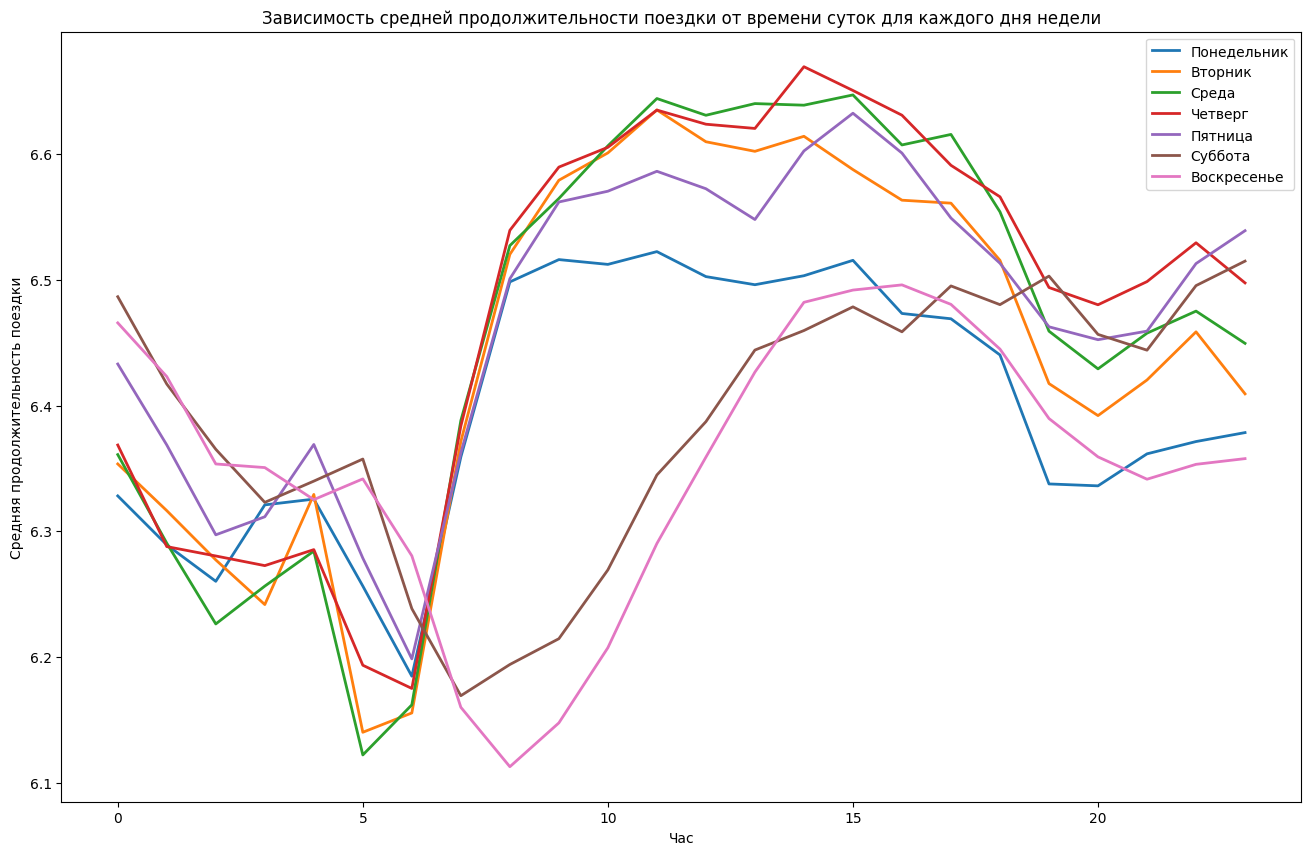

In [13]:
# График зависимости средней продолжительности поездки от времени суток для каждого дня недели

fig = plt.figure()
fig.set_size_inches(16, 10)

for day in sorted(processed_data.day_of_week.unique()):
    plt.plot(sorted(processed_data.query(f"day_of_week == {day}").hour.unique()),
             processed_data.query(f"day_of_week == {day}").groupby("hour")["log_trip_duration"].mean(),
             linewidth = 2)

plt.title("Зависимость средней продолжительности поездки от времени суток для каждого дня недели")
plt.xlabel("Час")
plt.ylabel("Средняя продолжительность поездки")
plt.legend(["Понедельник", "Вторник", "Среда", "Четверг", "Пятница", "Суббота", "Воскресенье"])

plt.show()

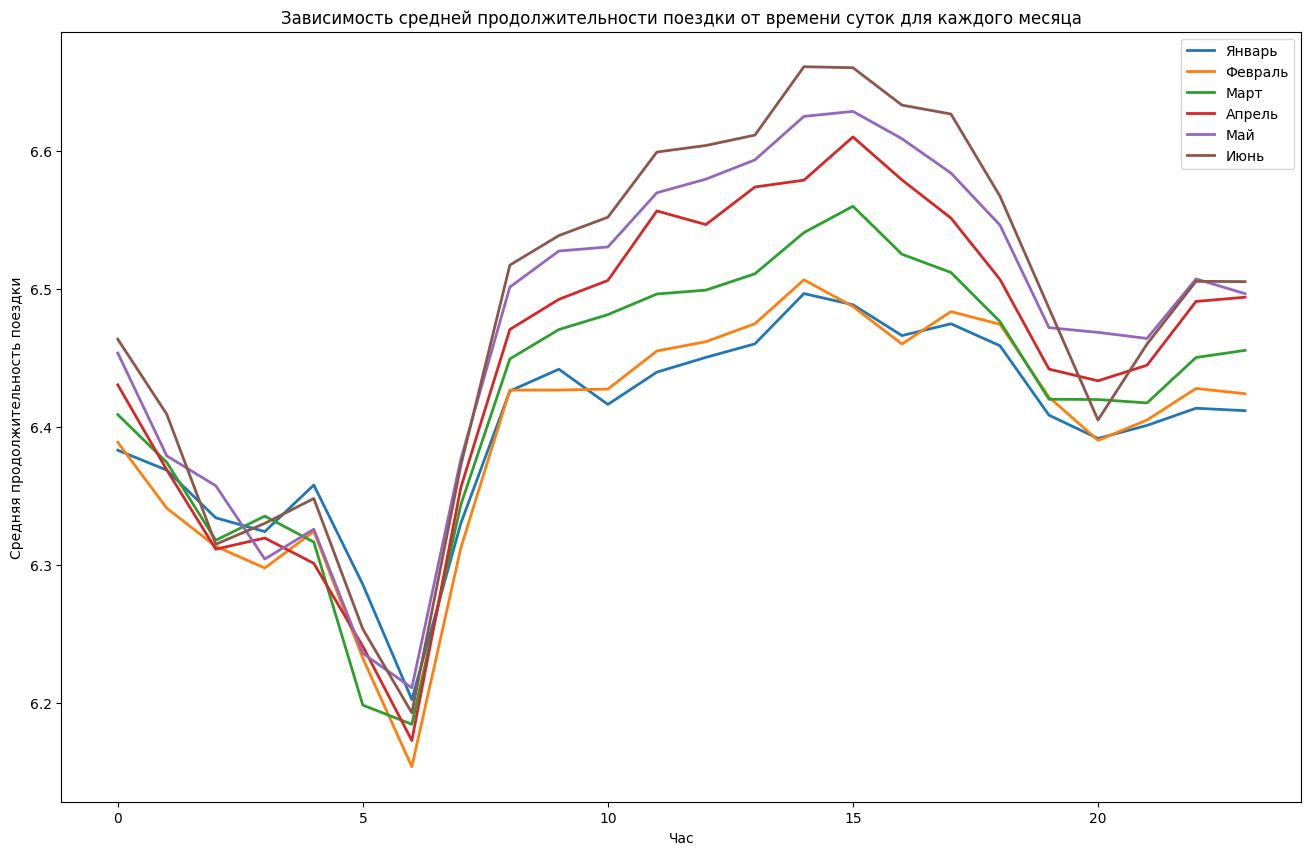

In [14]:
# График зависимости средней продолжительности поездки от времени суток для каждого месяца

fig = plt.figure()
fig.set_size_inches(16, 10)

for month_n in sorted(processed_data.month.unique()):
    plt.plot(sorted(processed_data.query(f"month == {month_n}").hour.unique()),
             processed_data.query(f"month == {month_n}").groupby("hour")["log_trip_duration"].mean(),
             linewidth = 2)

plt.title("Зависимость средней продолжительности поездки от времени суток для каждого месяца")
plt.xlabel("Час")
plt.ylabel("Средняя продолжительность поездки")
# plt.ylim((6, 7))
plt.legend(["Январь", "Февраль", "Март", "Апрель", "Май", "Июнь"])

plt.show()

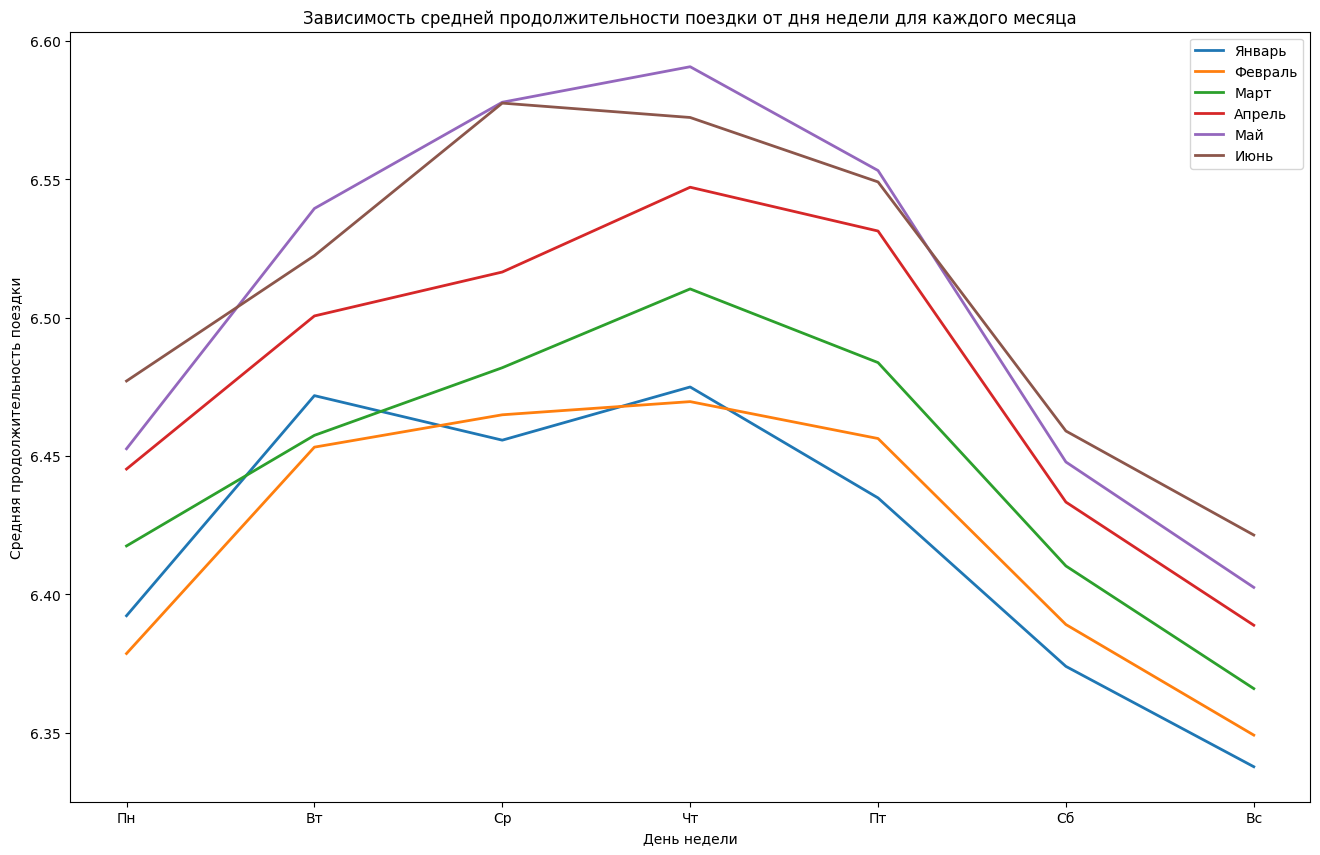

In [15]:
# График зависимости средней продолжительности поездки от дня недели для каждого месяца

fig = plt.figure()
fig.set_size_inches(16, 10)

for month_n in sorted(processed_data.month.unique()):
    plt.plot(sorted(processed_data.query(f"month == {month_n}").day_of_week.unique()),
             processed_data.query(f"month == {month_n}").groupby("day_of_week")["log_trip_duration"].mean(),
             linewidth = 2)

plt.title("Зависимость средней продолжительности поездки от дня недели для каждого месяца")
plt.xlabel("День недели")
plt.ylabel("Средняя продолжительность поездки")
plt.legend(["Январь", "Февраль", "Март", "Апрель", "Май", "Июнь"])
plt.xticks(sorted(processed_data.day_of_week.unique()),
           ["Пн", "Вт", "Ср", "Чт", "Пт", "Сб", "Вс"])

plt.show()

In [16]:
# Создаю словари для построения Boxplot-ов
# Например, в словаре month_dict ключем является месяц,
# а значениями по этому ключу - все значения таргета в этот месяц

month_dict = {}
for month in sorted(processed_data["month"].unique()):
    month_dict[month] = processed_data[processed_data["month"] == month]["log_trip_duration"]
    
day_of_week_dict = {}
for day in sorted(processed_data["day_of_week"].unique()):
    day_of_week_dict[day] = processed_data[processed_data["day_of_week"] == day]["log_trip_duration"]
    
hour_dict = {}
for hour in sorted(processed_data["hour"].unique()):
    hour_dict[hour] = processed_data[processed_data["hour"] == hour]["log_trip_duration"]

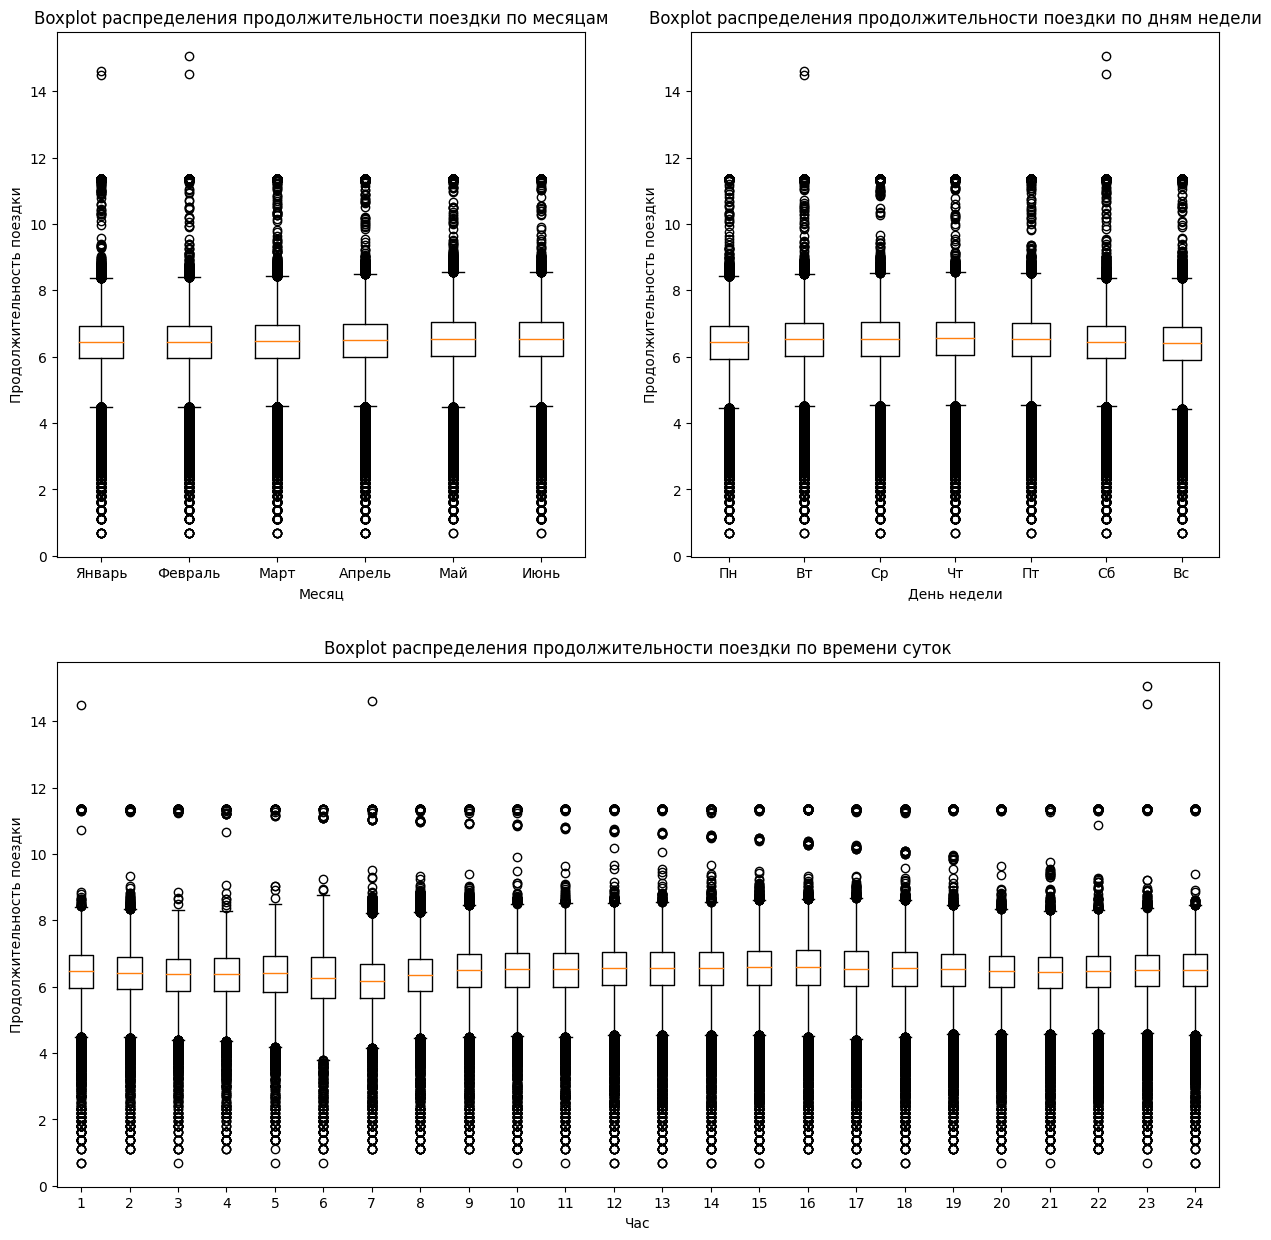

In [17]:
# Ящики с усами для различных: месяца, дня недели, времени суток

fig = plt.figure()
fig.set_size_inches(15, 15)

fig.add_subplot(2, 2, 1)
plt.boxplot(month_dict.values(), labels = ["Январь", "Февраль", "Март", "Апрель", "Май", "Июнь"])
plt.title("Boxplot распределения продолжительности поездки по месяцам")
plt.xlabel("Месяц")
plt.ylabel("Продолжительность поездки")

fig.add_subplot(2, 2, 2)
plt.boxplot(day_of_week_dict.values(), labels = ["Пн", "Вт", "Ср", "Чт", "Пт", "Сб", "Вс"])
plt.title("Boxplot распределения продолжительности поездки по дням недели")
plt.xlabel("День недели")
plt.ylabel("Продолжительность поездки")

fig.add_subplot(2, 1, 2)
plt.boxplot(hour_dict.values())
plt.title("Boxplot распределения продолжительности поездки по времени суток")
plt.xlabel("Час")
plt.ylabel("Продолжительность поездки")

plt.show()

Кажется, что полученные выводы из графиков выше достаточны для того, чтобы посчитать признаки, связанные с временем/датой поездки, достаточно важными. На их основе выделим еще пару.

Добавьте следующие бинарные признаки:


1. Была ли в день поездки буря (основываясь на единственном обнаруженном таком дне)
2. Является ли время поездки статистически самым проблемным, то есть час пиком?

Для создания 2ой фичи используйте следующую логику: посчитаем для каждой пары "день недели"-"время суток" среднее значение таргета. Найдем топ-10 самых "больших" пар. Если поездка была совершена во входящее в этот топ время, то ставим 1. Иначе - 0. Получается бинарный признак.

P.S. назовите колонки **anomaly** и **traffic_jam**

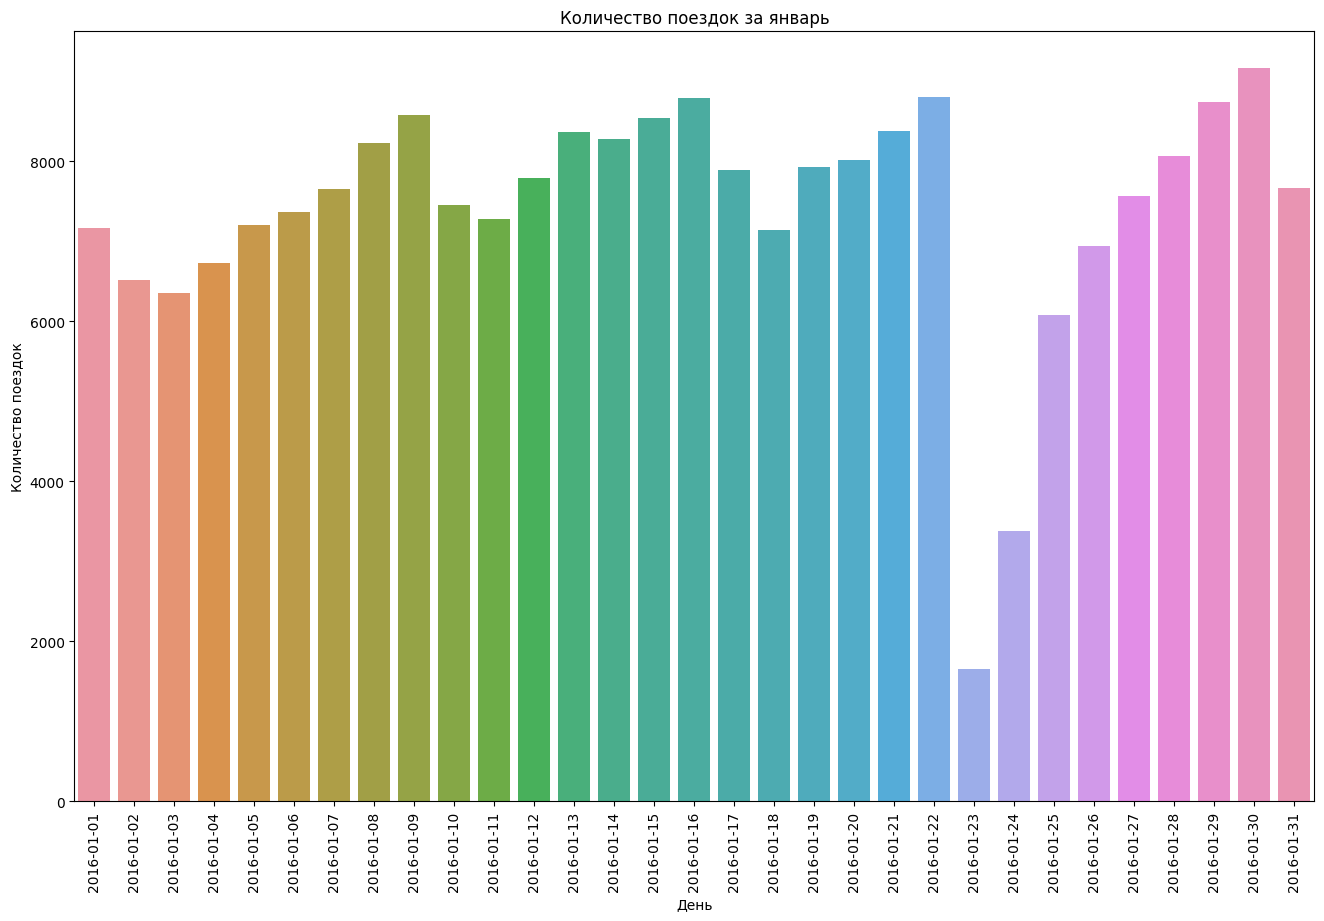

In [18]:
# Построим график распределения количества поездок в январе, чтобы понять, когда именно была метель

processed_data_january = processed_data.query("month == 1")

fig = plt.figure()
fig.set_size_inches(16, 10)

sns.countplot(x = processed_data_january.date, order = sorted(processed_data_january.date.unique()))
plt.title("Количество поездок за январь")
plt.xlabel("День")
plt.ylabel("Количество поездок")
plt.xticks(rotation = 90)

plt.show()

Из графика видно, что метель случилась 23 января 2016 года

In [19]:
# перевожу колонку date в тип даты
processed_data = processed_data.astype({"date": "datetime64[D]"})

In [20]:
### Создадим первый бинарный признак - anomaly
# Где дата 23 января 2016 года, ставим 1, в другие даты ставим 0

processed_data.loc[(processed_data["date"] == "2016-01-23"), "anomaly"] = 1
processed_data.anomaly = processed_data.anomaly.fillna(0)

In [21]:
### Создадим второй бинарный признак traffic_jam

In [22]:
# выделяем пары день недели-время суток и ищем для каждой пары среднее значение таргета
# находим топ-10 пар с самым высоким значением среднего таргета

data_traffic_jam = processed_data.groupby(["day_of_week", "hour"], as_index = False) \
                                  .agg({"log_trip_duration": "mean"}) \
                                  .sort_values("log_trip_duration", ascending = False) \
                                  [0:10]
data_traffic_jam

,day_of_week,hour,log_trip_duration
86,3,14,6.669526
87,3,15,6.650622
63,2,15,6.647091
59,2,11,6.644226
61,2,13,6.640205
62,2,14,6.638930
35,1,11,6.635141
83,3,11,6.635055
111,4,15,6.632537
88,3,16,6.630965


In [23]:
# создаем колонку со вторым бинарным признаком traffic_jam
# если день недели и час в processed_data совпадают с днем недели и часов в data_traffic_jam,
# то ставим 1, иначе 0

for index in data_traffic_jam.index:
    processed_data.loc[
        ((processed_data.day_of_week == data_traffic_jam.loc[index].day_of_week) &
        (processed_data.hour == data_traffic_jam.loc[index].hour)),
        "traffic_jam"
    ] = 1
processed_data.traffic_jam = processed_data.traffic_jam.fillna(0)

In [24]:
processed_data = processed_data.astype({"anomaly": "int", "traffic_jam": "int"})

In [25]:
processed_data.head()

,vendor_id,passenger_count,store_and_fwd_flag,distance_km,pickup_datetime,date,day_of_week,hour,month,log_trip_duration,anomaly,traffic_jam
id,,,,,,,,,,,,
id2875421,1,930.399753,0,1.500479,2016-03-14 17:24:55,2016-03-14,0,17,3,6.122493,0,0
id2377394,0,930.399753,0,1.807119,2016-06-12 00:43:35,2016-06-12,6,0,6,6.498282,0,0
id3858529,1,930.399753,0,6.392080,2016-01-19 11:35:24,2016-01-19,1,11,1,7.661527,0,1
id3504673,1,930.399753,0,1.487155,2016-04-06 19:32:31,2016-04-06,2,19,4,6.063785,0,0
id2181028,1,930.399753,0,1.189925,2016-03-26 13:30:55,2016-03-26,5,13,3,6.077642,0,0


Теперь колонки **pickup_datetime**, **date** можно убрать. А про оставшиеся **day_of_week**, **hour**, **month** необходимо подумать:

- С одной стороны, первые две можно убрать, так как на их основе была создана колонка **traffic_jam**
- С другой стороны, зависимость с колонкой **traffic_jam** нелинейная, поэтому можно попробовать использовать все фичи в комбинации. Конечно, лучше попробовать оба варианта и проэкспериментировать, но ради упрощения - оставим все колонки. Хоть **day_of_week**, **hour** и описываются числами, мы понимаем, что это скорее категориальные фичи. Потому что, например, отношение между 23:00 и 00:00 не такое же, как между числами 23 и 0. Закодируем их с помощью OneHotEncoder. 
- Последняя (**month**) очевидно категориальная. Можно закодировать ее тоже через OneHotEncoder.

In [26]:
processed_data = processed_data.drop(['pickup_datetime', 'date'], axis=1)

In [27]:
processed_data.head()

,vendor_id,passenger_count,store_and_fwd_flag,distance_km,day_of_week,hour,month,log_trip_duration,anomaly,traffic_jam
id,,,,,,,,,,
id2875421,1,930.399753,0,1.500479,0,17,3,6.122493,0,0
id2377394,0,930.399753,0,1.807119,6,0,6,6.498282,0,0
id3858529,1,930.399753,0,6.392080,1,11,1,7.661527,0,1
id3504673,1,930.399753,0,1.487155,2,19,4,6.063785,0,0
id2181028,1,930.399753,0,1.189925,5,13,3,6.077642,0,0


In [28]:
### Делаем OneHotEncoding и конкатим с processed_data

# кодирую колонки day_of_week, hour, month с помощью one-hot encoding
# для этого использую метод pd.get_dummies() и указываю его параметру drop_first = True,
# чтобы удалялась первая закодированная колонка 
# далее соединяю полученный датафрейм с processed_data
# и удаляю сами колонки day_of_week, hour из датафрейма

for col in ['day_of_week', 'hour', 'month']:
    processed_data = pd.concat([processed_data,
                                pd.get_dummies(processed_data[col], drop_first = True, prefix = f"{col}")],
                               axis = 1)
    processed_data.drop(columns = col, inplace = True)

processed_data.head()

,vendor_id,passenger_count,store_and_fwd_flag,distance_km,log_trip_duration,anomaly,traffic_jam,day_of_week_1,day_of_week_2,day_of_week_3,...,hour_19,hour_20,hour_21,hour_22,hour_23,month_2,month_3,month_4,month_5,month_6
id,,,,,,,,,,,,,,,,,,,,,
id2875421,1,930.399753,0,1.500479,6.122493,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
id2377394,0,930.399753,0,1.807119,6.498282,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
id3858529,1,930.399753,0,6.392080,7.661527,0,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
id3504673,1,930.399753,0,1.487155,6.063785,0,0,0,1,0,...,1,0,0,0,0,0,0,1,0,0
id2181028,1,930.399753,0,1.189925,6.077642,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0


In [29]:
processed_data[:5].to_csv("task7_4_f.csv", sep = ",")

In [30]:
new_data = pd.read_csv("Lesson_7_Step_4.csv")

Что же, мы с Вами научились с помощью EDA визуализаций понимать важность признаков не только постфактум, но и до того, как сформировался финальный датасет - на этапе **выделения базовых фичей**.

Обратимся теперь к методам фильтрации - например, применим корреляционный анализ для одной пары фичей, чтобы понять, нет ли относительно этих колонок в нашем датасете избытка информации. 

Вспомним так же изначальные вещественные признаки - distance_km, passenger_count

Посчитайте корреляцию между ними. Есть ли какие-то основания для беспокойства?

In [31]:
### Your code is here



In [32]:
# processed_data.head()

In [33]:
### На данный момент у нас 41 фича
### Представим, что хочется сократить их количество до 5.
### Воспользуемся для этим каким-нибудь методом обертки
### Например, метод прямого отбора

### Your code is here


In [34]:
### Перечислите фичи, которые окажутся наиболее желанными
### Your code is here


In [35]:
### Представим, что мы с Вами ничего не знаем про Кросс-Валидацию и отложенную выборку
### Замерьте качество линейной регрессии на данных фичах
### Сильно ли оно отличается от полученного на Кросс-Валидации в прошлом уроке в ДЗ?

### Your code is here

